In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib

from IPython.display import display, clear_output
from PIL import Image, ImageFilter, ImageFont, ImageDraw

In [2]:
# define an image size (128, 256, 512)
# the bigger the image size the longer it will take
imsize = 256
tranform_img = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])
unload_img = transforms.ToPILImage()
# func to resize image and turn it into a tensor
def image_loader(address):
    image = Image.open(address)
    image = tranform_img(image)
    image = image[None]
    image = Variable(image)
    return image.to(torch.float)
# tensor -> img
def show_img(tensor):
    image = tensor.clone()
    image = image.squeeze(0)
    image = unload_img(image)
    image = image.resize((imsize * 2, imsize * 2))
    plt.imshow(image)

# same as the show_img function but we also clear the cell output
plt.ion()
def animate_output(tensor):
    image = tensor.clone()
    image = image.squeeze(0)
    image = unload_img(image)
    clear_output(wait=True)
    display(image)

In [3]:
# lets define the loss between our content image and a random input
def calc_loss(input_features, target_features, weight):
    return F.mse_loss(input_features, target_features)*weight

In [4]:
# Use the CPU if no GPU is found
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Download the pre-trained vgg model
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

In [5]:
# Create class that will save the output of the previous layer
class SaveFeatures():
    features = None
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_to_save_features)
    def hook_to_save_features(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

# Register a hook after each Conv layer
saved_feature_layers = []
for i, layer in enumerate(vgg19.children()):
    if (isinstance(layer, nn.Conv2d)): 
        saved_feature_layers.append(SaveFeatures(vgg19[i]))

In [6]:
# Load content image (John Snow)
content_img = image_loader("data/snow_150x150.jpg")
# Put the content image through the network and save the features from the forward hook
vgg19(content_img)
content_fts_arr = [Variable(sf.features.clone()) for sf in saved_feature_layers]

In [7]:
# load stye image
style_img = image_loader("data/walker_150x150.jpg")

# put the style image through the network and save the features from the forward hook
vgg19(style_img)
style_fts_arr = [Variable(sf.features.clone()) for sf in saved_feature_layers]

# for the style loss we need another function to calc the gram of the input
# this will throw away the spacial info from the input but not the features
def to_gram(input):
    b, c, h, w = input.size()
    features = input.view(b*c, h*w)
    mm_features = torch.mm(features, features.t())
    return mm_features/input.numel()

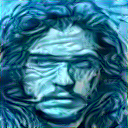

tensor([[[[0.5521, 0.5083, 0.5027,  ..., 0.3856, 0.1185, 0.2715],
          [0.4948, 0.3263, 0.4593,  ..., 0.2542, 0.0442, 0.1049],
          [0.5703, 0.4879, 0.6211,  ..., 0.4865, 0.2764, 0.3483],
          ...,
          [0.1882, 0.3225, 0.5454,  ..., 0.0000, 0.0325, 0.0000],
          [0.1643, 0.1146, 0.5187,  ..., 0.1053, 0.0693, 0.0000],
          [0.2061, 0.0960, 0.6278,  ..., 0.0004, 0.0008, 0.0000]],

         [[0.8706, 0.8606, 0.7272,  ..., 0.7030, 0.7278, 0.7082],
          [0.9588, 0.9150, 0.8685,  ..., 0.8754, 0.8441, 0.6128],
          [0.8536, 0.8922, 0.7713,  ..., 0.6953, 0.7158, 0.5726],
          ...,
          [0.5949, 0.5414, 0.5220,  ..., 0.3252, 0.2265, 0.3508],
          [0.5476, 0.5330, 0.5504,  ..., 0.3491, 0.1423, 0.4332],
          [0.4717, 0.5631, 0.6697,  ..., 0.4312, 0.3755, 0.3790]],

         [[0.9785, 0.9773, 0.9363,  ..., 0.8644, 0.9795, 0.9939],
          [0.9605, 0.9171, 0.9910,  ..., 0.8868, 0.8951, 0.8585],
          [0.9049, 0.9809, 0.9579,  ..., 0

In [8]:
# Load input image (John Snow)
input_img = Variable(image_loader("data/snow_150x150.jpg"), requires_grad=True).to(torch.float)
# Fire up the optimiser!
epochs = 80
num = 0
optimizer = optim.LBFGS([input_img], lr=1)
while num <= epochs:
    def closure():
        global num
        input_img.data.clamp_(0, 1)
        print(f"Num: {num}")
        optimizer.zero_grad()
        # put the Input image through the network
        vgg19(input_img)
        # save the outputs from the network for the input image
        input_fts_arr = [layer.features for layer in saved_feature_layers]
        #style loss from the 2nd -> 7th Layers
        style_loss = sum([calc_loss(to_gram(i_fts), to_gram(s_fts), 10000000000) for i_fts, s_fts in zip(input_fts_arr[1:6], style_fts_arr[1:6])])
        # send the content and input features from Layer 3 to the loss function
        content_loss = sum([calc_loss(i_fts, c_fts, 1000) for i_fts, c_fts in zip(input_fts_arr[2], content_fts_arr[2])])
        # combine both losses
        loss = style_loss + content_loss
        # Update the input image
        loss.backward()
        print(loss)
        animate_output(input_img)
        num += 1
        return loss
    optimizer.step(closure)
input_img.data.clamp_(0, 1)
show_img(input_img)